In [2]:
import os
import timeit

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight

2024-03-01 15:22:58.135391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 15:22:58.135483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 15:22:58.264541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
np.random.seed(12049)

In [4]:
def get_plot_loss_acc(model, model_name):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

In [5]:
def compute_confusion_matrix(
    ytrue, ypred, class_names, model_name
):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

In [6]:
def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]:.2f}")
    print(f"{name} accuracy: {score_model[1]:.2f}")


def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [7]:
base_dir = "/kaggle/input/knee-osteoarthritis-dataset-with-severity"
train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

In [8]:
model_name = "Inception ResNet V2"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

target_size = (224, 224)
epochs = 100
batch_size = 256
img_shape = (224, 224, 3)

# Save model
save_model_ft = os.path.join('models', f'model_{model_name}_ft.hdf5')

In [9]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,
)

In [10]:
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [11]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [12]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}
{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


In [13]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01, 
                min_lr=1e-10, patience=4, mode='auto'
            )

In [14]:
model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

219055592/219055592 [==============================] - 1s 0us/step


In [15]:
# for layer in model.layers:
#     layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 54344421 (207.31 MB)
Trainable params: 54283877 (207.08 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________


In [16]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early, plateau],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/100


I0000 00:00:1709306675.394866     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


181/181 [==============================] - 211s 685ms/step - loss: 1.2327 - accuracy: 0.4078 - val_loss: 4.6129 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 2/100
181/181 [==============================] - 80s 442ms/step - loss: 0.9406 - accuracy: 0.5370 - val_loss: 2.5023 - val_accuracy: 0.4334 - lr: 0.0010
Epoch 3/100
181/181 [==============================] - 80s 439ms/step - loss: 0.8859 - accuracy: 0.5485 - val_loss: 1.0538 - val_accuracy: 0.5835 - lr: 0.0010
Epoch 4/100
181/181 [==============================] - 79s 435ms/step - loss: 0.8255 - accuracy: 0.5787 - val_loss: 1.5100 - val_accuracy: 0.3862 - lr: 0.0010
Epoch 5/100
181/181 [==============================] - 80s 442ms/step - loss: 0.7656 - accuracy: 0.6042 - val_loss: 1.1419 - val_accuracy: 0.5642 - lr: 0.0010
Epoch 6/100
181/181 [==============================] - 80s 443ms/step - loss: 0.7396 - accuracy: 0.6097 - val_loss: 1.2614 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 7/100
181/181 [==============================] - 80

In [17]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model Inception ResNet V2 fine tuning executed in 16.82 minutes


In [18]:
tf.keras.saving.get_custom_objects().clear()


# Upon registration, you can optionally specify a package or a name.
# If left blank, the package defaults to `Custom` and the name defaults to
# the class name.
@tf.keras.saving.register_keras_serializable(package="MyLayers")
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def call(self, x):
        return x * self.factor

    def get_config(self):
        return {"factor": self.factor}


@tf.keras.saving.register_keras_serializable(package="my_package", name="custom_fn")
def custom_fn(x):
    return x**2

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# Assuming your model is named 'model'
model_ft.save('../models/customInceptionResNetV2.keras')


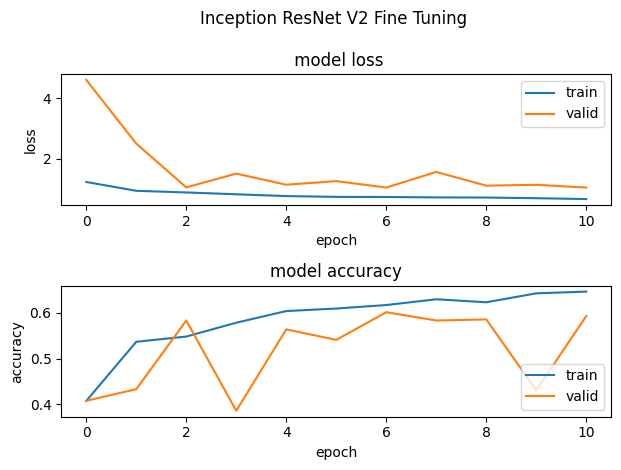

In [19]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [20]:
get_evaluate(valid_generator, "Valid", model_ft)

26/26 [==============================] - 3s 107ms/step - loss: 1.0538 - accuracy: 0.5835
Valid loss: 1.05
Valid accuracy: 0.58


In [21]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

26/26 [==============================] - 6s 100ms/step
Accuracy Score - Inception ResNet V2: 0.58
Balanced Accuracy Score - Inception ResNet V2: 0.63


              precision    recall  f1-score   support

           0       0.69      0.72      0.70       328
           1       0.34      0.25      0.29       153
           2       0.52      0.50      0.51       212
           3       0.61      0.74      0.67       106
           4       0.62      0.93      0.75        27

    accuracy                           0.58       826
   macro avg       0.56      0.63      0.58       826
weighted avg       0.57      0.58      0.57       826



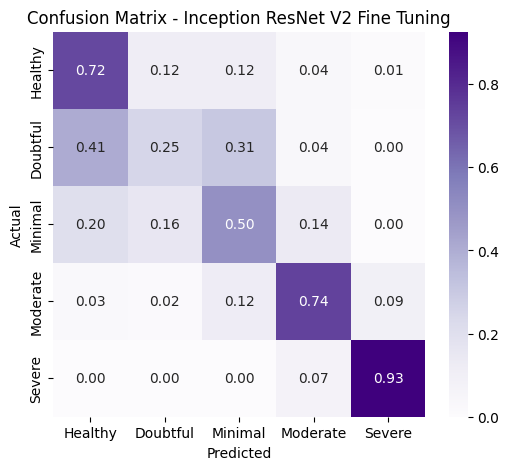

In [22]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)